In [8]:
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms, models

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

# Check Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using Device:", device)



✅ Using Device: cuda


In [2]:
# Dataset Path
dataset_path = '/kaggle/input/skin-diseases-dataset/Skin_Diseases_Dataset2'

train_dir = '/kaggle/input/skin-disease-dataset/Skin_Diseases_Dataset2/train'
test_dir = '/kaggle/input/skin-disease-dataset/Skin_Diseases_Dataset2/val'

# Data Transforms
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



In [3]:
# Load Dataset
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

# Class Weights for Imbalanced Dataset
class_counts = [0] * len(train_dataset.classes)
for _, label in train_dataset:
    class_counts[label] += 1

class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
sample_weights = [class_weights[label] for _, label in train_dataset]

sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)


In [4]:
# Define ResNet18 Model
resnet18_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_ftrs = resnet18_model.fc.in_features
resnet18_model.fc = nn.Linear(num_ftrs, 23)  # Adjust for 23 skin disease classes

# Move Model to Device
resnet18_model = resnet18_model.to(device)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 200MB/s]


In [5]:
# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18_model.parameters(), lr=1e-4, weight_decay=1e-4)

# Training Configuration
num_epochs = 50
best_val_acc = 0.0
best_model = copy.deepcopy(resnet18_model.state_dict())

# Metric Tracking
train_losses, val_losses = [], []
train_accs, val_accs = [], []
time_per_epoch = []

print("🚀 Starting ResNet18 Training for 50 Epochs with Constant Learning Rate...")

for epoch in range(num_epochs):
    start_time = time.time()
    
    ########################################
    # 🚦 Training Phase
    ########################################
    resnet18_model.train()
    running_loss, correct, total = 0.0, 0, 0
    
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = resnet18_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_acc = 100.0 * correct / total
    
    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)
    
    ########################################
    # 🧪 Validation Phase
    ########################################
    resnet18_model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet18_model(images)
            loss = criterion(outputs, labels)
            
            val_running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    
    epoch_val_loss = val_running_loss / len(test_loader)
    epoch_val_acc = 100.0 * val_correct / val_total
    
    val_losses.append(epoch_val_loss)
    val_accs.append(epoch_val_acc)
    
    epoch_time = time.time() - start_time
    time_per_epoch.append(epoch_time)
    
    print(f"📊 Epoch [{epoch+1}/{num_epochs}] | 🕒 Time: {epoch_time:.2f}s | "
          f"📉 Train Loss: {epoch_train_loss:.4f} | 📈 Train Acc: {epoch_train_acc:.2f}% | "
          f"📉 Val Loss: {epoch_val_loss:.4f} | 📈 Val Acc: {epoch_val_acc:.2f}% | "
          f"⚙️ LR: {optimizer.param_groups[0]['lr']:.6f}")


🚀 Starting ResNet18 Training for 50 Epochs with Constant Learning Rate...


Epoch 1/50: 100%|██████████| 44/44 [00:12<00:00,  3.65it/s]


📊 Epoch [1/50] | 🕒 Time: 14.65s | 📉 Train Loss: 1.7138 | 📈 Train Acc: 51.94% | 📉 Val Loss: 0.8741 | 📈 Val Acc: 71.27% | ⚙️ LR: 0.000100


Epoch 2/50: 100%|██████████| 44/44 [00:10<00:00,  4.04it/s]


📊 Epoch [2/50] | 🕒 Time: 12.36s | 📉 Train Loss: 0.7052 | 📈 Train Acc: 77.47% | 📉 Val Loss: 0.5818 | 📈 Val Acc: 77.90% | ⚙️ LR: 0.000100


Epoch 3/50: 100%|██████████| 44/44 [00:10<00:00,  4.11it/s]


📊 Epoch [3/50] | 🕒 Time: 12.26s | 📉 Train Loss: 0.5416 | 📈 Train Acc: 82.78% | 📉 Val Loss: 0.5934 | 📈 Val Acc: 77.90% | ⚙️ LR: 0.000100


Epoch 4/50: 100%|██████████| 44/44 [00:10<00:00,  4.01it/s]


📊 Epoch [4/50] | 🕒 Time: 12.51s | 📉 Train Loss: 0.4450 | 📈 Train Acc: 85.94% | 📉 Val Loss: 0.5226 | 📈 Val Acc: 82.32% | ⚙️ LR: 0.000100


Epoch 5/50: 100%|██████████| 44/44 [00:11<00:00,  3.99it/s]


📊 Epoch [5/50] | 🕒 Time: 12.54s | 📉 Train Loss: 0.3519 | 📈 Train Acc: 88.81% | 📉 Val Loss: 0.5600 | 📈 Val Acc: 77.90% | ⚙️ LR: 0.000100


Epoch 6/50: 100%|██████████| 44/44 [00:10<00:00,  4.02it/s]


📊 Epoch [6/50] | 🕒 Time: 12.45s | 📉 Train Loss: 0.2762 | 📈 Train Acc: 91.54% | 📉 Val Loss: 0.5473 | 📈 Val Acc: 80.66% | ⚙️ LR: 0.000100


Epoch 7/50: 100%|██████████| 44/44 [00:10<00:00,  4.07it/s]


📊 Epoch [7/50] | 🕒 Time: 12.34s | 📉 Train Loss: 0.2649 | 📈 Train Acc: 91.82% | 📉 Val Loss: 0.5181 | 📈 Val Acc: 83.43% | ⚙️ LR: 0.000100


Epoch 8/50: 100%|██████████| 44/44 [00:10<00:00,  4.08it/s]


📊 Epoch [8/50] | 🕒 Time: 12.39s | 📉 Train Loss: 0.2344 | 📈 Train Acc: 91.68% | 📉 Val Loss: 0.5885 | 📈 Val Acc: 81.77% | ⚙️ LR: 0.000100


Epoch 9/50: 100%|██████████| 44/44 [00:11<00:00,  3.89it/s]


📊 Epoch [9/50] | 🕒 Time: 12.84s | 📉 Train Loss: 0.2492 | 📈 Train Acc: 91.39% | 📉 Val Loss: 0.5706 | 📈 Val Acc: 82.87% | ⚙️ LR: 0.000100


Epoch 10/50: 100%|██████████| 44/44 [00:11<00:00,  3.91it/s]


📊 Epoch [10/50] | 🕒 Time: 12.77s | 📉 Train Loss: 0.1627 | 📈 Train Acc: 94.98% | 📉 Val Loss: 0.5404 | 📈 Val Acc: 81.22% | ⚙️ LR: 0.000100


Epoch 11/50: 100%|██████████| 44/44 [00:10<00:00,  4.04it/s]


📊 Epoch [11/50] | 🕒 Time: 12.37s | 📉 Train Loss: 0.1135 | 📈 Train Acc: 97.42% | 📉 Val Loss: 0.4861 | 📈 Val Acc: 84.53% | ⚙️ LR: 0.000100


Epoch 12/50: 100%|██████████| 44/44 [00:10<00:00,  4.05it/s]


📊 Epoch [12/50] | 🕒 Time: 12.37s | 📉 Train Loss: 0.1341 | 📈 Train Acc: 96.41% | 📉 Val Loss: 0.5358 | 📈 Val Acc: 85.08% | ⚙️ LR: 0.000100


Epoch 13/50: 100%|██████████| 44/44 [00:10<00:00,  4.19it/s]


📊 Epoch [13/50] | 🕒 Time: 12.01s | 📉 Train Loss: 0.1281 | 📈 Train Acc: 95.98% | 📉 Val Loss: 0.5513 | 📈 Val Acc: 84.53% | ⚙️ LR: 0.000100


Epoch 14/50: 100%|██████████| 44/44 [00:11<00:00,  3.98it/s]


📊 Epoch [14/50] | 🕒 Time: 12.61s | 📉 Train Loss: 0.1041 | 📈 Train Acc: 96.27% | 📉 Val Loss: 0.5057 | 📈 Val Acc: 85.64% | ⚙️ LR: 0.000100


Epoch 15/50: 100%|██████████| 44/44 [00:10<00:00,  4.02it/s]


📊 Epoch [15/50] | 🕒 Time: 12.44s | 📉 Train Loss: 0.1279 | 📈 Train Acc: 95.98% | 📉 Val Loss: 0.5919 | 📈 Val Acc: 85.64% | ⚙️ LR: 0.000100


Epoch 16/50: 100%|██████████| 44/44 [00:10<00:00,  4.02it/s]


📊 Epoch [16/50] | 🕒 Time: 12.44s | 📉 Train Loss: 0.1133 | 📈 Train Acc: 96.41% | 📉 Val Loss: 0.5866 | 📈 Val Acc: 83.98% | ⚙️ LR: 0.000100


Epoch 17/50: 100%|██████████| 44/44 [00:10<00:00,  4.08it/s]


📊 Epoch [17/50] | 🕒 Time: 12.27s | 📉 Train Loss: 0.0703 | 📈 Train Acc: 98.13% | 📉 Val Loss: 0.4495 | 📈 Val Acc: 87.85% | ⚙️ LR: 0.000100


Epoch 18/50: 100%|██████████| 44/44 [00:10<00:00,  4.06it/s]


📊 Epoch [18/50] | 🕒 Time: 12.50s | 📉 Train Loss: 0.1015 | 📈 Train Acc: 96.84% | 📉 Val Loss: 0.5910 | 📈 Val Acc: 85.64% | ⚙️ LR: 0.000100


Epoch 19/50: 100%|██████████| 44/44 [00:11<00:00,  3.98it/s]


📊 Epoch [19/50] | 🕒 Time: 12.55s | 📉 Train Loss: 0.0996 | 📈 Train Acc: 97.13% | 📉 Val Loss: 0.5712 | 📈 Val Acc: 83.43% | ⚙️ LR: 0.000100


Epoch 20/50: 100%|██████████| 44/44 [00:10<00:00,  4.09it/s]


📊 Epoch [20/50] | 🕒 Time: 12.25s | 📉 Train Loss: 0.0764 | 📈 Train Acc: 97.70% | 📉 Val Loss: 0.6396 | 📈 Val Acc: 83.43% | ⚙️ LR: 0.000100


Epoch 21/50: 100%|██████████| 44/44 [00:10<00:00,  4.04it/s]


📊 Epoch [21/50] | 🕒 Time: 12.54s | 📉 Train Loss: 0.0895 | 📈 Train Acc: 98.13% | 📉 Val Loss: 0.7755 | 📈 Val Acc: 83.43% | ⚙️ LR: 0.000100


Epoch 22/50: 100%|██████████| 44/44 [00:10<00:00,  4.10it/s]


📊 Epoch [22/50] | 🕒 Time: 12.25s | 📉 Train Loss: 0.0940 | 📈 Train Acc: 97.27% | 📉 Val Loss: 0.4589 | 📈 Val Acc: 86.74% | ⚙️ LR: 0.000100


Epoch 23/50: 100%|██████████| 44/44 [00:10<00:00,  4.03it/s]


📊 Epoch [23/50] | 🕒 Time: 12.51s | 📉 Train Loss: 0.0561 | 📈 Train Acc: 98.42% | 📉 Val Loss: 0.5407 | 📈 Val Acc: 83.98% | ⚙️ LR: 0.000100


Epoch 24/50: 100%|██████████| 44/44 [00:10<00:00,  4.05it/s]


📊 Epoch [24/50] | 🕒 Time: 12.37s | 📉 Train Loss: 0.0535 | 📈 Train Acc: 98.85% | 📉 Val Loss: 0.4909 | 📈 Val Acc: 85.64% | ⚙️ LR: 0.000100


Epoch 25/50: 100%|██████████| 44/44 [00:10<00:00,  4.10it/s]


📊 Epoch [25/50] | 🕒 Time: 12.23s | 📉 Train Loss: 0.0377 | 📈 Train Acc: 98.71% | 📉 Val Loss: 0.5701 | 📈 Val Acc: 82.87% | ⚙️ LR: 0.000100


Epoch 26/50: 100%|██████████| 44/44 [00:10<00:00,  4.03it/s]


📊 Epoch [26/50] | 🕒 Time: 12.81s | 📉 Train Loss: 0.0615 | 📈 Train Acc: 97.99% | 📉 Val Loss: 0.5431 | 📈 Val Acc: 84.53% | ⚙️ LR: 0.000100


Epoch 27/50: 100%|██████████| 44/44 [00:10<00:00,  4.00it/s]


📊 Epoch [27/50] | 🕒 Time: 12.54s | 📉 Train Loss: 0.0377 | 📈 Train Acc: 99.28% | 📉 Val Loss: 0.5127 | 📈 Val Acc: 86.74% | ⚙️ LR: 0.000100


Epoch 28/50: 100%|██████████| 44/44 [00:11<00:00,  3.98it/s]


📊 Epoch [28/50] | 🕒 Time: 12.58s | 📉 Train Loss: 0.0337 | 📈 Train Acc: 99.14% | 📉 Val Loss: 0.5497 | 📈 Val Acc: 83.43% | ⚙️ LR: 0.000100


Epoch 29/50: 100%|██████████| 44/44 [00:10<00:00,  4.05it/s]


📊 Epoch [29/50] | 🕒 Time: 12.39s | 📉 Train Loss: 0.0305 | 📈 Train Acc: 99.43% | 📉 Val Loss: 0.6056 | 📈 Val Acc: 85.64% | ⚙️ LR: 0.000100


Epoch 30/50: 100%|██████████| 44/44 [00:10<00:00,  4.16it/s]


📊 Epoch [30/50] | 🕒 Time: 12.07s | 📉 Train Loss: 0.0214 | 📈 Train Acc: 99.43% | 📉 Val Loss: 0.6365 | 📈 Val Acc: 85.08% | ⚙️ LR: 0.000100


Epoch 31/50: 100%|██████████| 44/44 [00:10<00:00,  4.05it/s]


📊 Epoch [31/50] | 🕒 Time: 12.52s | 📉 Train Loss: 0.0346 | 📈 Train Acc: 99.14% | 📉 Val Loss: 0.6149 | 📈 Val Acc: 83.43% | ⚙️ LR: 0.000100


Epoch 32/50: 100%|██████████| 44/44 [00:11<00:00,  3.99it/s]


📊 Epoch [32/50] | 🕒 Time: 12.55s | 📉 Train Loss: 0.0204 | 📈 Train Acc: 99.71% | 📉 Val Loss: 0.6270 | 📈 Val Acc: 85.08% | ⚙️ LR: 0.000100


Epoch 33/50: 100%|██████████| 44/44 [00:10<00:00,  4.08it/s]


📊 Epoch [33/50] | 🕒 Time: 12.28s | 📉 Train Loss: 0.0289 | 📈 Train Acc: 99.57% | 📉 Val Loss: 0.5610 | 📈 Val Acc: 86.74% | ⚙️ LR: 0.000100


Epoch 34/50: 100%|██████████| 44/44 [00:11<00:00,  3.95it/s]


📊 Epoch [34/50] | 🕒 Time: 12.75s | 📉 Train Loss: 0.0565 | 📈 Train Acc: 98.28% | 📉 Val Loss: 0.8452 | 📈 Val Acc: 81.22% | ⚙️ LR: 0.000100


Epoch 35/50: 100%|██████████| 44/44 [00:10<00:00,  4.02it/s]


📊 Epoch [35/50] | 🕒 Time: 12.48s | 📉 Train Loss: 0.0476 | 📈 Train Acc: 98.71% | 📉 Val Loss: 0.6619 | 📈 Val Acc: 82.32% | ⚙️ LR: 0.000100


Epoch 36/50: 100%|██████████| 44/44 [00:11<00:00,  3.98it/s]


📊 Epoch [36/50] | 🕒 Time: 12.67s | 📉 Train Loss: 0.0433 | 📈 Train Acc: 99.28% | 📉 Val Loss: 0.7041 | 📈 Val Acc: 82.32% | ⚙️ LR: 0.000100


Epoch 37/50: 100%|██████████| 44/44 [00:11<00:00,  3.91it/s]


📊 Epoch [37/50] | 🕒 Time: 12.82s | 📉 Train Loss: 0.0639 | 📈 Train Acc: 98.28% | 📉 Val Loss: 0.7533 | 📈 Val Acc: 80.66% | ⚙️ LR: 0.000100


Epoch 38/50: 100%|██████████| 44/44 [00:11<00:00,  3.99it/s]


📊 Epoch [38/50] | 🕒 Time: 12.54s | 📉 Train Loss: 0.0377 | 📈 Train Acc: 98.85% | 📉 Val Loss: 0.6327 | 📈 Val Acc: 82.32% | ⚙️ LR: 0.000100


Epoch 39/50: 100%|██████████| 44/44 [00:10<00:00,  4.01it/s]


📊 Epoch [39/50] | 🕒 Time: 12.54s | 📉 Train Loss: 0.0355 | 📈 Train Acc: 99.00% | 📉 Val Loss: 0.7055 | 📈 Val Acc: 83.98% | ⚙️ LR: 0.000100


Epoch 40/50: 100%|██████████| 44/44 [00:10<00:00,  4.15it/s]


📊 Epoch [40/50] | 🕒 Time: 12.10s | 📉 Train Loss: 0.0342 | 📈 Train Acc: 99.28% | 📉 Val Loss: 0.7941 | 📈 Val Acc: 79.01% | ⚙️ LR: 0.000100


Epoch 41/50: 100%|██████████| 44/44 [00:10<00:00,  4.05it/s]


📊 Epoch [41/50] | 🕒 Time: 12.53s | 📉 Train Loss: 0.0334 | 📈 Train Acc: 99.00% | 📉 Val Loss: 0.6763 | 📈 Val Acc: 83.43% | ⚙️ LR: 0.000100


Epoch 42/50: 100%|██████████| 44/44 [00:11<00:00,  4.00it/s]


📊 Epoch [42/50] | 🕒 Time: 12.52s | 📉 Train Loss: 0.0381 | 📈 Train Acc: 99.14% | 📉 Val Loss: 0.6152 | 📈 Val Acc: 85.08% | ⚙️ LR: 0.000100


Epoch 43/50: 100%|██████████| 44/44 [00:10<00:00,  4.05it/s]


📊 Epoch [43/50] | 🕒 Time: 12.39s | 📉 Train Loss: 0.0616 | 📈 Train Acc: 98.57% | 📉 Val Loss: 0.9118 | 📈 Val Acc: 77.90% | ⚙️ LR: 0.000100


Epoch 44/50: 100%|██████████| 44/44 [00:11<00:00,  3.99it/s]


📊 Epoch [44/50] | 🕒 Time: 12.56s | 📉 Train Loss: 0.0942 | 📈 Train Acc: 96.56% | 📉 Val Loss: 0.6749 | 📈 Val Acc: 85.64% | ⚙️ LR: 0.000100


Epoch 45/50: 100%|██████████| 44/44 [00:10<00:00,  4.11it/s]


📊 Epoch [45/50] | 🕒 Time: 12.19s | 📉 Train Loss: 0.0543 | 📈 Train Acc: 98.57% | 📉 Val Loss: 0.6249 | 📈 Val Acc: 83.43% | ⚙️ LR: 0.000100


Epoch 46/50: 100%|██████████| 44/44 [00:10<00:00,  4.09it/s]


📊 Epoch [46/50] | 🕒 Time: 12.26s | 📉 Train Loss: 0.0575 | 📈 Train Acc: 98.57% | 📉 Val Loss: 0.6798 | 📈 Val Acc: 82.32% | ⚙️ LR: 0.000100


Epoch 47/50: 100%|██████████| 44/44 [00:10<00:00,  4.08it/s]


📊 Epoch [47/50] | 🕒 Time: 12.28s | 📉 Train Loss: 0.0364 | 📈 Train Acc: 98.71% | 📉 Val Loss: 0.7385 | 📈 Val Acc: 82.87% | ⚙️ LR: 0.000100


Epoch 48/50: 100%|██████████| 44/44 [00:10<00:00,  4.08it/s]


📊 Epoch [48/50] | 🕒 Time: 12.27s | 📉 Train Loss: 0.0339 | 📈 Train Acc: 99.28% | 📉 Val Loss: 0.7614 | 📈 Val Acc: 82.32% | ⚙️ LR: 0.000100


Epoch 49/50: 100%|██████████| 44/44 [00:10<00:00,  4.00it/s]


📊 Epoch [49/50] | 🕒 Time: 12.55s | 📉 Train Loss: 0.0327 | 📈 Train Acc: 99.28% | 📉 Val Loss: 0.6893 | 📈 Val Acc: 86.19% | ⚙️ LR: 0.000100


Epoch 50/50: 100%|██████████| 44/44 [00:10<00:00,  4.04it/s]


📊 Epoch [50/50] | 🕒 Time: 12.40s | 📉 Train Loss: 0.0392 | 📈 Train Acc: 98.71% | 📉 Val Loss: 0.6422 | 📈 Val Acc: 85.08% | ⚙️ LR: 0.000100


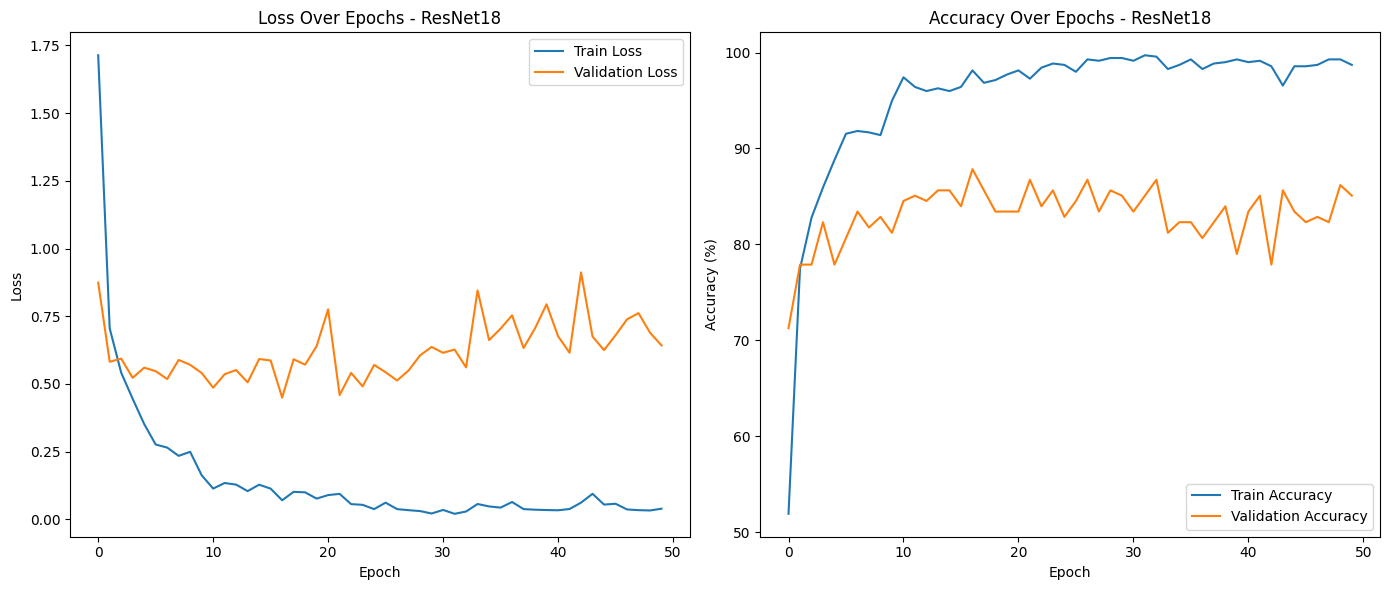

In [6]:
# Plot Loss and Accuracy Curves
plt.figure(figsize=(14, 6))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs - ResNet18')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Over Epochs - ResNet18')
plt.legend()

plt.tight_layout()
plt.show()


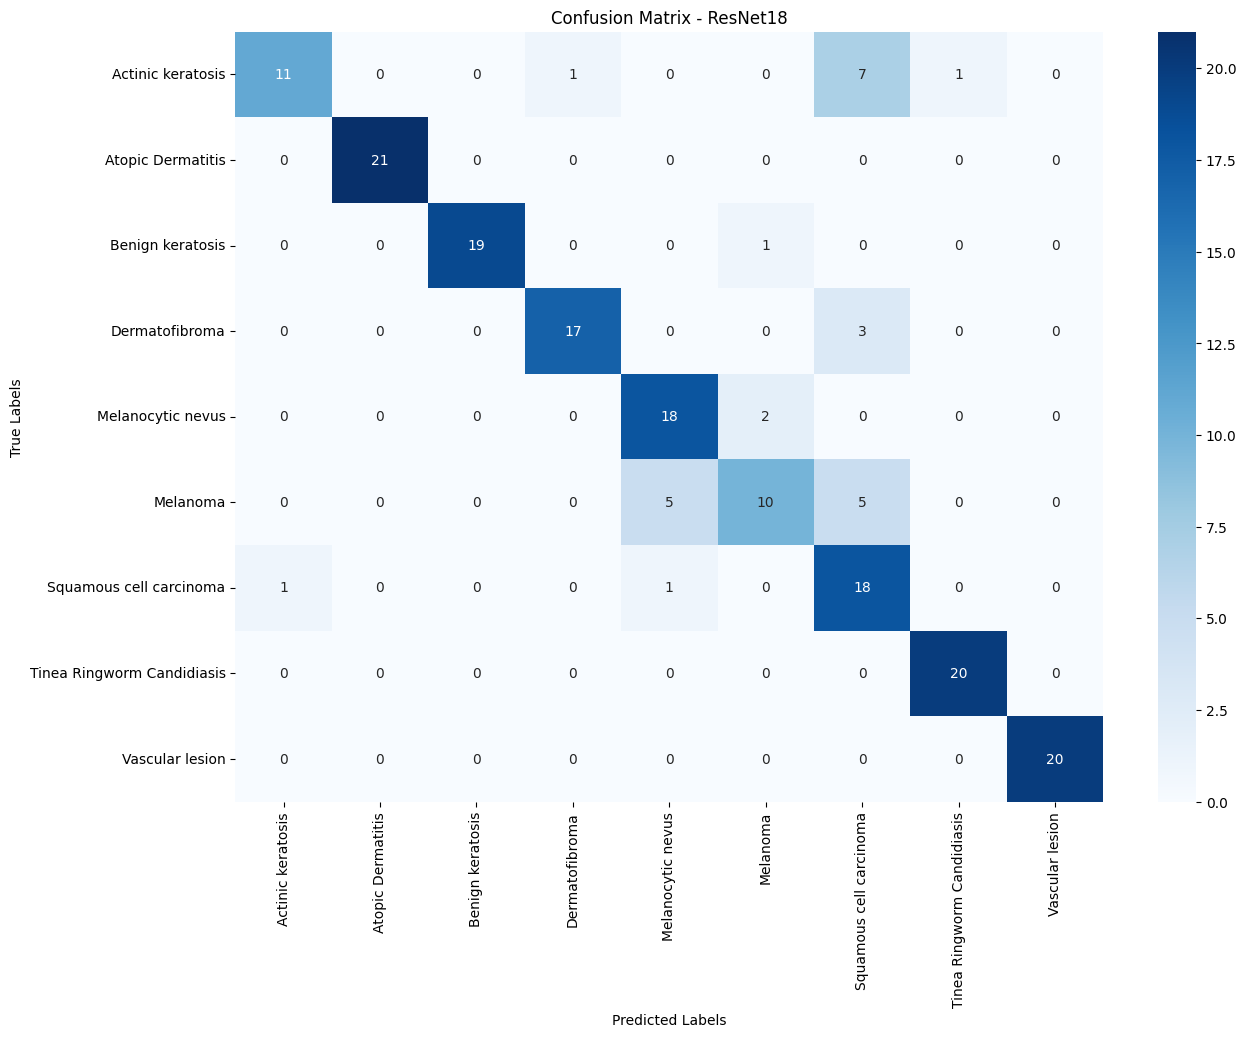

✅ Classification Report:
                            precision    recall  f1-score   support

         Actinic keratosis       0.92      0.55      0.69        20
         Atopic Dermatitis       1.00      1.00      1.00        21
          Benign keratosis       1.00      0.95      0.97        20
            Dermatofibroma       0.94      0.85      0.89        20
         Melanocytic nevus       0.75      0.90      0.82        20
                  Melanoma       0.77      0.50      0.61        20
   Squamous cell carcinoma       0.55      0.90      0.68        20
Tinea Ringworm Candidiasis       0.95      1.00      0.98        20
           Vascular lesion       1.00      1.00      1.00        20

                  accuracy                           0.85       181
                 macro avg       0.88      0.85      0.85       181
              weighted avg       0.88      0.85      0.85       181


✅ Overall Metrics:
Accuracy: 0.8508
Error Rate: 0.1492
Precision (Macro Avg): 0.8754
Re

In [9]:
# Initialize lists for predictions and ground truth labels
all_preds, all_labels = [], []

# Evaluation Phase
resnet18_model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18_model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.title('Confusion Matrix - ResNet18')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification Report
print("✅ Classification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

# Calculate Overall Metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
error_rate = 1 - accuracy

# Specificity Calculation (Custom for Multi-Class)
def calculate_specificity_per_class(cm):
    specificity_per_class = []
    num_classes = cm.shape[0]
    
    for i in range(num_classes):
        TP = cm[i, i]
        FP = np.sum(cm[:, i]) - TP
        FN = np.sum(cm[i, :]) - TP
        TN = np.sum(cm) - (TP + FP + FN)
        
        specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
        specificity_per_class.append(specificity)
    
    specificity_avg = np.mean(specificity_per_class)
    return specificity_avg, specificity_per_class

specificity_avg, specificity_per_class = calculate_specificity_per_class(cm)

# Print Metrics
print("\n✅ Overall Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Error Rate: {error_rate:.4f}")
print(f"Precision (Macro Avg): {precision:.4f}")
print(f"Recall (Macro Avg): {recall:.4f}")
print(f"F1-Score (Macro Avg): {f1:.4f}")
print(f"Specificity (Macro Avg): {specificity_avg:.4f}")

# Print Class-wise Specificity
print("\n✅ Specificity per Class:")
for i, spec in enumerate(specificity_per_class):
    print(f"{train_dataset.classes[i]}: {spec:.4f}")

